In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import os

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

C:\Users\edufe\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Abre os dados

In [2]:
#Verifica os dados no diretorio

Data = os.listdir("../../Filter/Tweets_Filtered/")
for i in range(len(Data)):
    Data[i] = Data[i].split(".")[0]
    
Pessoas = ["realDonaldTrump", "jairbolsonaro", "hbredda", "gui_benchimol", "pedrocerize"]

NoticiasPolitica = ["OGloboPolitica", "folha_poder", "GloboNews", "EstadaoPolitica", 
                    "RevistaEpoca", "valoreconomico", "g1politica", "conexaopolitica", "EstadaoEconomia", 
                    "UOLEconomia", "folha_mercado", "g1economia", "OGlobo_Economia"]

Noticias = ["UOL", "folha", "g1", "VEJA", "cartacapital", "RevistaISTOE"]

#Monta um dicionario com todos datasets de twites de todas as pessoas
Alvo = NoticiasPolitica


AllData = pd.DataFrame()
for i in Alvo:
    if i in Data:
        MoreData = pd.read_csv("../../Filter/Tweets_Filtered/{0}".format(i+".csv"), sep=";", decimal=",", encoding='utf-16')
        AllData = pd.concat([AllData, MoreData])
    else:
        print("{0} não disponivel".format(i))
        
AllData = AllData.reset_index(drop=True)

In [3]:
label_encoder = LabelEncoder()

label_encoder.fit(AllData.Pessoa)
AllData['Pessoa_id'] = label_encoder.transform(AllData.Pessoa)

In [4]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id
3207,folha_poder,2019-04-23 15:18:02,presidente do stj vê lula como cidadão comum e...,7,23,1,9
19606,g1politica,2019-03-30 16:02:12,agu consegue liminar e suspende decisão que im...,7,38,1,11
20478,g1politica,2019-02-20 00:28:13,governo precisa estreitar relação com congress...,4,19,1,11
23341,conexaopolitica,2019-02-25 17:12:50,ao vivo mike afirma essas pessoas bloquearam a...,129,719,0,7
10205,EstadaoPolitica,2019-02-05 18:33:40,pezão inelegível até 2022 tribunal regional el...,12,32,1,1


In [5]:
document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 13.991752676762806.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 30.


In [6]:
smallerthen4 = document_lengths <= 5

for i in range(len(document_lengths)):
    if smallerthen4[i]:
        AllData = AllData.drop(i)

document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['document_sentences'] = df.Texto.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(sentences),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(AllData)

In [9]:
def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.Texto))
    df['tokenized_text'] = list(df.tokenized_text)

lda_get_good_tokens(AllData)

In [10]:
print(nltk.corpus.stopwords.words('portuguese')[0:20])

['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as']


In [11]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('portuguese')[0:20]
    
    del(stopwords[stopwords.index("não")])
    ManualStop = ["istoégente", "expressoepoca", "globonews", "estudioi", "rt", "andreiasadi",
                  "’", "‘", "”", "“", "r", ",", ".", "…", "diz", "à", "ao"]
    Numbers = list(range(10))
    stopwords = stopwords + ManualStop + Numbers
    
    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(AllData)

In [12]:
dictionary = Dictionary(documents=AllData.stopwords_removed.values)

print("Found {} words.".format(len(dictionary.values())))

Found 29532 words.


In [13]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 12050 words.


In [14]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stopwords_removed))
    
document_to_bow(AllData)

In [15]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    document_to_bow(df)

In [16]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow
26067,EstadaoEconomia,2018-11-26 15:00:00,para atrair clientes bancos estendem promoções...,1,2,1,0,[para atrair clientes bancos estendem promoçõe...,"[[para, atrair, clientes, bancos, estendem, pr...","[para, atrair, clientes, bancos, estendem, pro...","[atrair, clientes, bancos, estendem, promoções...","[(159, 1), (412, 1), (1244, 1), (3376, 1), (33..."
8737,GloboNews,2019-02-27 17:20:18,relembre outras colisões entre trens da superv...,1,16,1,2,[relembre outras colisões entre trens da super...,"[[relembre, outras, colisões, entre, trens, da...","[relembre, outras, colisões, entre, trens, da,...","[relembre, outras, colisões, entre, trens, sup...","[(63, 1), (571, 1), (572, 1), (624, 1), (664, ..."
19109,g1politica,2019-04-23 15:48:11,relator da pec da previdência na ccj anuncia a...,2,11,1,11,[relator da pec da previdência na ccj anuncia ...,"[[relator, da, pec, da, previdência, na, ccj, ...","[relator, da, pec, da, previdência, na, ccj, a...","[relator, pec, previdência, ccj, anuncia, alte...","[(42, 1), (145, 1), (499, 1), (922, 1), (995, ..."
2246,OGloboPolitica,2019-01-11 20:45:21,mpf pede condenação de rocha loures por mala c...,10,25,1,3,[mpf pede condenação de rocha loures por mala ...,"[[mpf, pede, condenação, de, rocha, loures, po...","[mpf, pede, condenação, de, rocha, loures, por...","[mpf, pede, condenação, rocha, loures, mala, 5...","[(86, 1), (166, 1), (196, 1), (472, 1), (479, ..."
3530,folha_poder,2019-04-04 05:20:02,família de lula deve ir à justiça contra hospi...,6,28,1,9,[família de lula deve ir à justiça contra hosp...,"[[família, de, lula, deve, ir, à, justiça, con...","[família, de, lula, deve, ir, à, justiça, cont...","[família, lula, deve, ir, justiça, contra, hos...","[(12, 1), (15, 1), (22, 1), (92, 1), (408, 1),..."


# Análise de tópicos

In [17]:
corpus = AllData.bow

In [18]:
num_topics = 10
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=11,
                        chunksize=10000,
                        iterations = 5,
                        passes=7,
                        alpha='asymmetric')

In [22]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

AllData['lda_features'] = list(map(lambda doc:
                              document_to_lda_features(LDAmodel, doc),
                              AllData.bow))

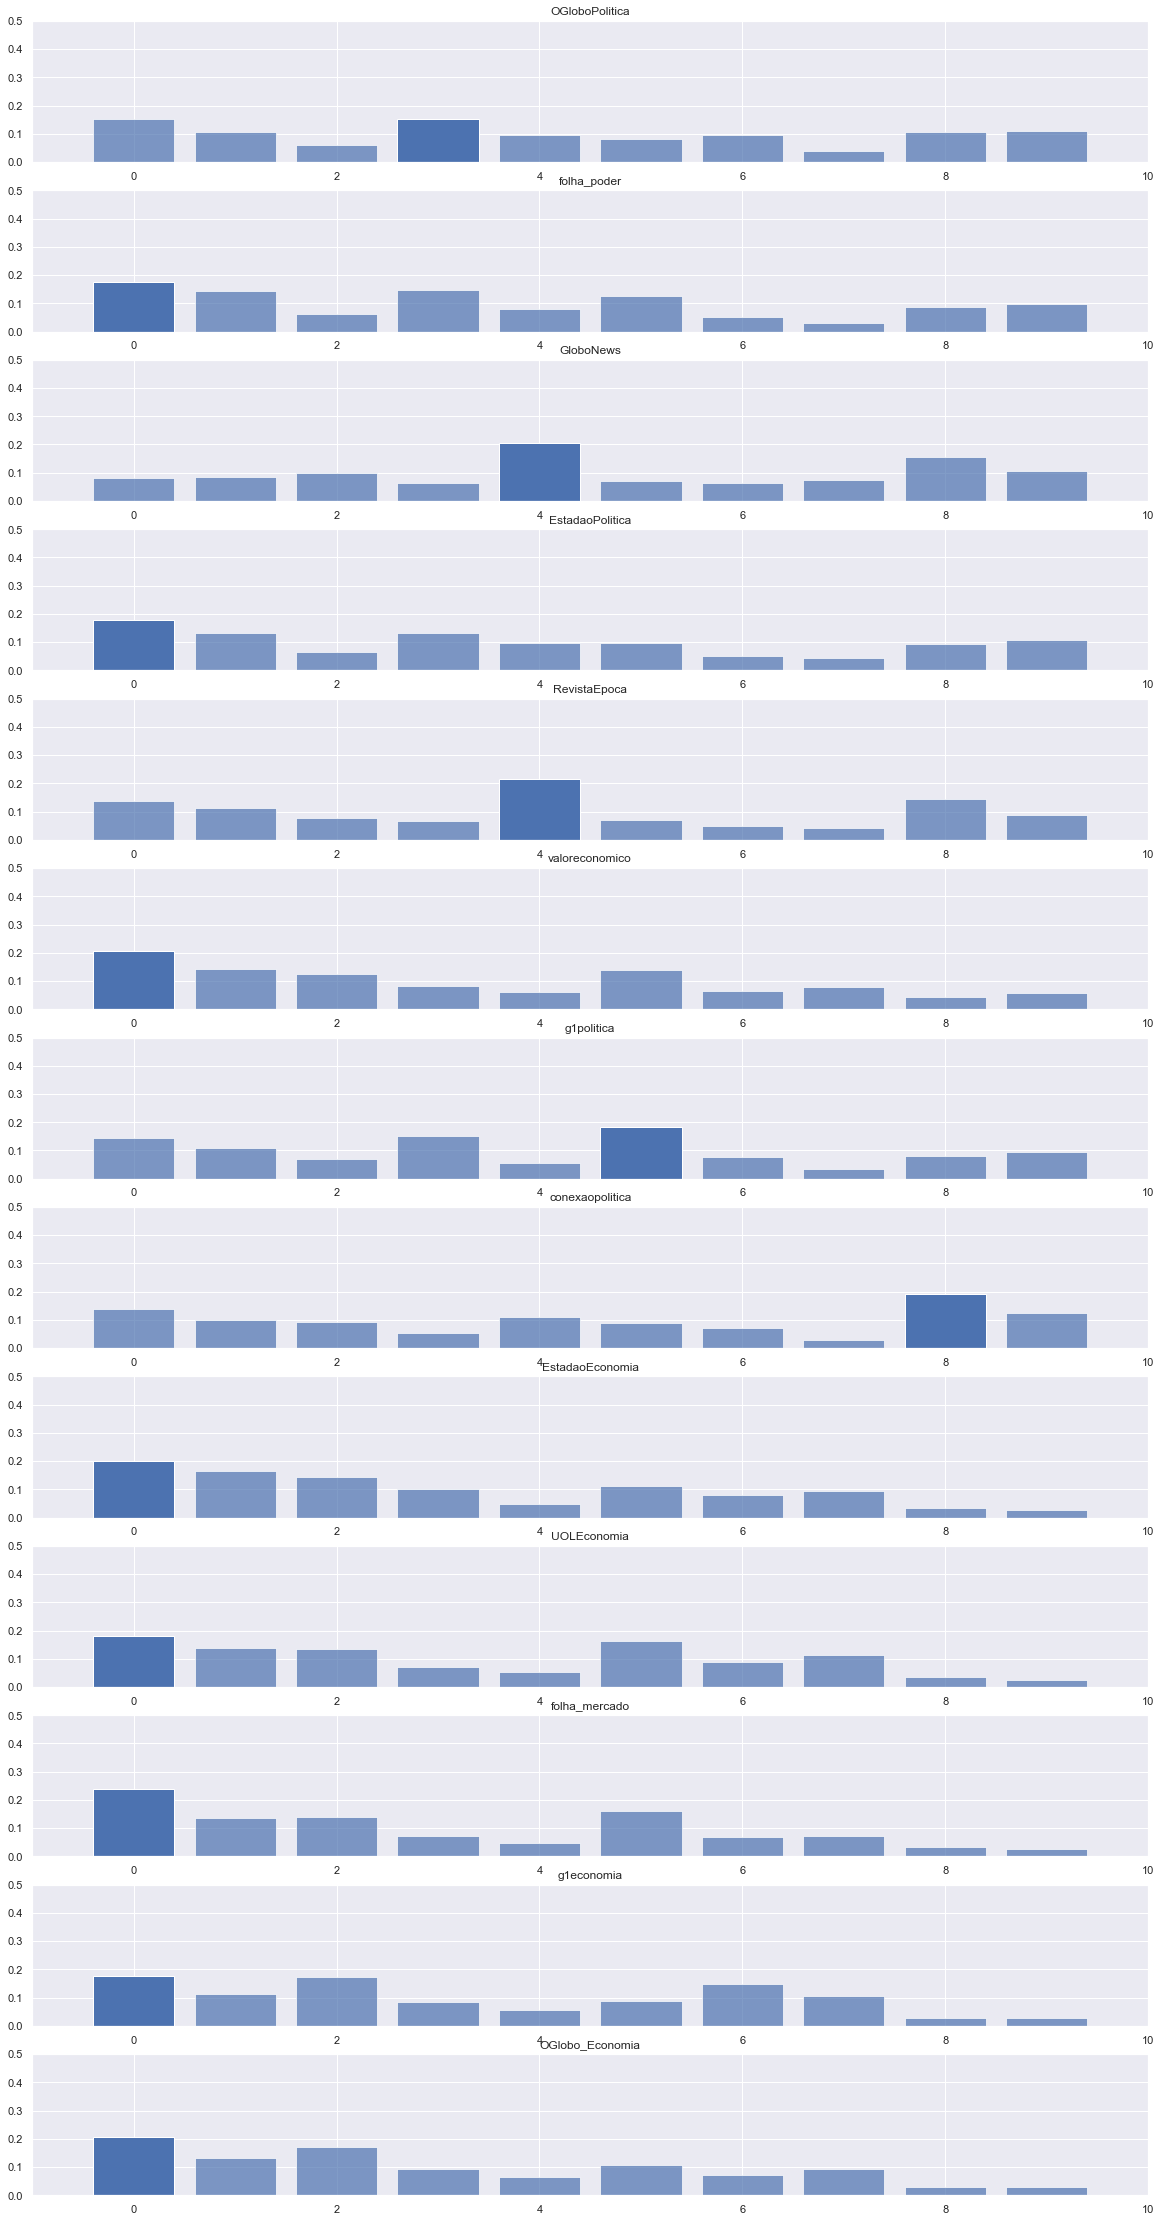

In [23]:
topic_distribution = []
for i in Alvo:
    topic_distribution.append(AllData.loc[AllData.Pessoa == i, 'lda_features'].mean())
    
ax = 1 

Axes = [ax]*len(Alvo)
fig, Axes = plt.subplots(len(Alvo),figsize=(20,40))

nr_top_bars = 1

for i in range(len(Axes)):
    Axes[i].set_title(Alvo[i])

for ax, distribution in zip(Axes, topic_distribution):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, num_topics)
    ax.set_ylim(0,0.5)

In [24]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow,lda_features
31275,UOLEconomia,2019-01-04 19:20:15,dólar tem maior queda semanal em 3 meses e fec...,6,22,1,6,[dólar tem maior queda semanal em 3 meses e fe...,"[[dólar, tem, maior, queda, semanal, em, 3, me...","[dólar, tem, maior, queda, semanal, em, 3, mes...","[dólar, tem, maior, queda, semanal, 3, meses, ...","[(61, 1), (338, 1), (928, 1), (1142, 1), (1195...","[0.01867477037012577, 0.03789157420396805, 0.0..."
26134,EstadaoEconomia,2018-11-09 15:30:00,governo estuda pacote para reduzir conta de luz,3,6,1,0,[governo estuda pacote para reduzir conta de l...,"[[governo, estuda, pacote, para, reduzir, cont...","[governo, estuda, pacote, para, reduzir, conta...","[governo, estuda, pacote, reduzir, conta, luz]","[(111, 1), (172, 1), (639, 1), (2281, 1), (232...","[0.2715478837490082, 0.4289078712463379, 0.017..."
28581,EstadaoEconomia,2017-09-05 12:57:04,produção industrial sobe 0 8 em julho e regist...,5,3,1,0,[produção industrial sobe 0 8 em julho e regis...,"[[produção, industrial, sobe, 0, 8, em, julho,...","[produção, industrial, sobe, 0, 8, em, julho, ...","[produção, industrial, sobe, 0, 8, julho, regi...","[(313, 1), (1690, 1), (2738, 1), (3477, 1), (4...","[0.01872151717543602, 0.014118212275207043, 0...."
21631,g1politica,2018-12-21 19:56:08,toffoli nega mudar regras sobre escolha de gab...,1,3,1,11,[toffoli nega mudar regras sobre escolha de ga...,"[[toffoli, nega, mudar, regras, sobre, escolha...","[toffoli, nega, mudar, regras, sobre, escolha,...","[toffoli, nega, mudar, regras, sobre, escolha,...","[(27, 1), (209, 1), (447, 1), (599, 1), (908, ...","[0.10789380967617035, 0.017225494608283043, 0...."
3998,folha_poder,2019-03-09 05:18:02,235 deputados apoiam frente de defesa do servi...,11,17,1,9,[235 deputados apoiam frente de defesa do serv...,"[[235, deputados, apoiam, frente, de, defesa, ...","[235, deputados, apoiam, frente, de, defesa, d...","[235, deputados, apoiam, frente, defesa, servi...","[(166, 1), (296, 1), (406, 1), (407, 1), (550,...","[0.2916732132434845, 0.013897992670536041, 0.0..."


In [25]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model."""
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [26]:
from pprint import pprint

print("Looking up top words from top topics")
for x in range(num_topics):
    top_words = get_topic_top_words(LDAmodel, x, nr_top_words=50)
    pprint(f"For topic {x+1}, the top words are:")
    pprint("{0}".format(", ".join(top_words)))
    pprint("")
print("")

Looking up top words from top topics
'For topic 1, the top words are:'
('é, sobre, brasil, governo, bolsonaro, contra, são, lula, não, presidente, '
 'após, pede, stf, pela, ex, vai, últimas, ser, petrobras, vale, até, justiça, '
 'bi, ação, caixa, milhões, eua, nos, anuncia, us, decreto, dados, temer, '
 'empresas, estadão, avianca, venda, foi, como, das, paulo, rio, prisão, '
 'armas, regras, previdência, dos, bancos, campanha, nas')
''
'For topic 2, the top words are:'
('bolsonaro, não, é, tem, governo, mas, brasil, ministro, vai, sobre, acordo, '
 'quer, dos, terá, pode, presidente, entre, após, país, são, câmara, estadão, '
 'contra, está, crise, 2018, paulo, bi, previdência, faz, ainda, últimas, '
 'veja, embraer, maia, das, empresa, maior, milhões, como, reforma, anos, '
 'tenta, eua, futuro, 2, psl, petróleo, sp, apoio')
''
'For topic 3, the top words are:'
('brasil, 1, não, eua, bolsonaro, dos, china, 2019, economia, mercado, das, '
 'pib, 2018, bc, crescimento, quer, é, brasi

In [27]:
TopicsData = np.array(list(AllData["lda_features"]))
TopicsData = np.transpose(TopicsData)

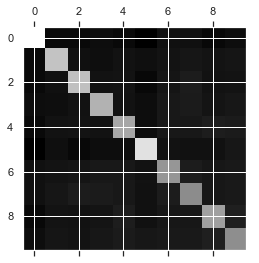

In [28]:
CovMatrix = np.cov(TopicsData)
plt.matshow(CovMatrix, cmap=plt.cm.gray)
plt.show()

## Filtra as ações

In [29]:
Stocks = ["ibov", "ITUB4", "PETR4", "Vale3", "BBDC4", "ABEV3", "BBAS3", "SANB3", "LREN3"]

Cols = {}
for i in range(len(Stocks)):
    Cols[Stocks[i]] = [i*4+i, i*4+i+1, i*4+i+2, i*4+i+3]

In [31]:
Var = 'ibov'
bolsa = pd.read_excel('../../Dados_Bolsa/Twt.xlsx', sheet_name="1h", usecols=Cols[Var],  skiprow=[0])

In [32]:
headers = list(bolsa.keys())
myheaders = [Var, "Price", "Volume", "Ticks"]

for i in range(len(headers)):
    bolsa.rename(columns={headers[i]: myheaders[i]}, inplace=True)
    
bolsa = bolsa.dropna()
bolsa.drop(bolsa.head(1).index,inplace=True)

bolsa = bolsa.reset_index(drop=True)

In [33]:
bolsa.head(5)

,ibov,Price,Volume,Ticks
0,2018-10-08 10:00:00,86283.7,0,119
1,2018-10-08 11:00:00,85686.7,0,120
2,2018-10-08 12:00:00,85408.6,0,120
3,2018-10-08 13:00:00,85267.7,0,120
4,2018-10-08 14:00:00,85686.7,0,120


In [34]:
ibov_len  = len(bolsa[Var])
ibov_len

1110

In [35]:
import datetime

ibov_data_precos = {}
DeadZoneUp = 0.3e-2
DeadZoneDown = 0.6e-2
# célula para identificar os preços de abertura e fechamento de cada dia
for i in range(0, ibov_len):
    data_completa = datetime.datetime.strptime(str(bolsa[Var][i]), '%Y-%m-%d %H:%M:%S')
    preco = bolsa['Price'][i]
    data = data_completa.strftime("%Y-%m-%d")
    if data not in ibov_data_precos:
        ibov_data_precos[data] = {}
        ibov_data_precos[data]['abertura'] = preco
        #caso só tenhamos informação de uma hora dentro de um dia, assumimos esse preco como o de fechamento tbm
        ibov_data_precos[data]['fechamento'] = preco 
        dia_anterior_completo =  data_completa - datetime.timedelta(days=1)
        dia_anterior_data = dia_anterior_completo.strftime("%Y-%m-%d")
        
        if(dia_anterior_data in ibov_data_precos):
            dia_anterior_fechamento = ibov_data_precos[dia_anterior_data]['fechamento']
            
            if(preco > dia_anterior_fechamento + dia_anterior_fechamento*DeadZoneUp):
                ibov_data_precos[data]['variacao'] = 2 #Subiu
            elif (preco < dia_anterior_fechamento - dia_anterior_fechamento*DeadZoneDown):
                ibov_data_precos[data]['variacao'] = 0 #Desceu
            else:
                ibov_data_precos[data]['variacao'] = 1
        else:
            #se não tivermos informações sobre o dia anterior, assumimos que a variacao foi neutra
            ibov_data_precos[data]['variacao'] = 0 
    else:
        if i < (ibov_len - 1):
            data_seguinte = datetime.datetime.strptime(str(bolsa[Var][i+1]), '%Y-%m-%d %H:%M:%S')
            if data_seguinte.date() > data_completa.date():
                ibov_data_precos[data]['fechamento'] = preco

Datesibov = list(ibov_data_precos.keys())
                
for i in range(4):
    print(Datesibov[i], ibov_data_precos[Datesibov[i]])

2018-10-08 {'abertura': 86283.67, 'fechamento': 86083.91, 'variacao': 0}
2018-10-09 {'abertura': 85864.42, 'fechamento': 86087.55, 'variacao': 1}
2018-10-10 {'abertura': 84590.04, 'fechamento': 83679.11, 'variacao': 0}
2018-10-11 {'abertura': 84492.8, 'fechamento': 82921.08, 'variacao': 2}


## Cria os Datasets

In [36]:
OutputData = []
InputData = []
for i in range(len(AllData)):
    data_completa = datetime.datetime.strptime(str(AllData["Data"].iloc[i]), '%Y-%m-%d %H:%M:%S')
    data = data_completa.strftime("%Y-%m-%d")
    if data in list(ibov_data_precos.keys()):
        OutputData.append(ibov_data_precos[data]["variacao"])
        Data = list(AllData['lda_features'].iloc[i])
        Data.append(AllData['Retweets'].iloc[i])
        Data.append(AllData['Likes'].iloc[i])
        Data.append(AllData['Pessoa_id'].iloc[i])
        InputData.append(Data)

In [37]:
len(OutputData), len(InputData), len(InputData[0])

(26261, 26261, 13)

In [38]:
print(InputData[1])

[0.024275464937090874, 0.014088485389947891, 0.011341421864926815, 0.570182740688324, 0.0081682363525033, 0.007167374715209007, 0.08136371523141861, 0.005756734404712915, 0.005241000559180975, 0.27241483330726624, 11, 24, 3]


In [39]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_classes, test_classes = train_test_split(InputData, OutputData, 
                                                                        test_size=0.2, stratify=OutputData)

## Distribuição das Classes:

In [40]:
trainlen = len(train_classes)
testlen = len(test_classes)

print("Treinamento:")
print(train_classes.count(0)/trainlen)
print(train_classes.count(1)/trainlen)
print(train_classes.count(2)/trainlen)
print()
print("Teste:")
print(test_classes.count(0)/testlen)
print(test_classes.count(1)/testlen)
print(test_classes.count(2)/testlen)

Treinamento:
0.32828
0.37888
0.29284

Teste:
0.2950039651070579
0.41712926249008725
0.28786677240285485


## Aplicação de Modelos

In [41]:
from sklearn.model_selection import cross_val_predict, cross_val_score

### Regressão Logistica

In [42]:
from sklearn.linear_model import LogisticRegression

Losgisticclf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

scores = cross_val_score(Losgisticclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.37133067 0.36897418 0.3803702 ]
0.37355835083900707


### Decision Tree

In [43]:
from sklearn import tree

tree = tree.DecisionTreeClassifier()

scores = cross_val_score(tree, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.3340948  0.34989719 0.33672303]
0.3402383425202384


### Randon Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

RandonForestclf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

scores = cross_val_score(RandonForestclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.3486008  0.33687457 0.36048903]
0.34865480074870975


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 30, 100], 
    'min_impurity_decrease': [1e-5, 1e-6, 0]}
  ]

RandonForestclf = RandomForestClassifier(n_estimators=10, min_impurity_decrease=1e-3)

grid_search = GridSearchCV(RandonForestclf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

grid_search.fit(InputData, OutputData)

print(grid_search.best_params_, grid_search.best_score_)

BestParams = grid_search.best_params_

RandonForestclf = RandomForestClassifier(n_estimators=BestParams["n_estimators"], 
                                         min_impurity_decrease=BestParams["min_impurity_decrease"])

## Best Model

In [ ]:
TopClassifier = RandonForestclf

y_pred = cross_val_predict(TopClassifier, InputData, OutputData, cv=3)

In [ ]:
Output_Pred = list(y_pred)

print("Resultado Modelo:")
print(Output_Pred.count(0)/len(Output_Pred))
print(Output_Pred.count(1)/len(Output_Pred))
print(Output_Pred.count(2)/len(Output_Pred))

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(OutputData, Output_Pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
InputDataa = np.array(InputData)
OutputDataa = np.array(OutputData)
Output_Preda = np.array(Output_Pred)

In [ ]:
AllResults = pd.DataFrame(InputData)
AllResults["Output"]= OutputDataa
AllResults["Output_pred"]= Output_Preda

AllResults.sample(5)

In [ ]:
ResultCorr = np.array(AllResults.corr())
AllResults.corr()

In [ ]:
plt.matshow(ResultCorr)
plt.show()

In [ ]:
row_sums = ResultCorr.sum(axis=1, keepdims=True)
norm_corr = ResultCorr / row_sums
np.fill_diagonal(norm_corr, 0.005)

plt.matshow(norm_corr)
plt.show()